#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа:
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [ ] Проверено на семинаре

In [ ]:
import xml.etree.ElementTree as ET

def parse_xml(xml_file):

  tree = ET.parse(xml_file)
  root = tree.getroot()
  size = root.find("size")
  width = int(size.find("width").text)
  height = int(size.find("height").text)
  obj = root.find("object")
  obj_name = obj.find("name").text
  bndbox = obj.find("bndbox")

  raw_coords = {
      "xmin": float(bndbox.find("xmin").text),
      "ymin": float(bndbox.find("ymin").text),
      "xmax": float(bndbox.find("xmax").text),
      "ymax": float(bndbox.find("ymax").text)
  }
  scaled_coords = {
      "xmin": raw_coords["xmin"] / width,
      "ymin": raw_coords["ymin"] / height,
      "xmax": raw_coords["xmax"] / width,
      "ymax": raw_coords["ymax"] / height
  }

  return {
      "raw": raw_coords,
      "scaled": scaled_coords,
      "obj_name": obj_name
  }

In [ ]:
import zipfile
import os

zip_file_path = "animals.zip"
extract_dir = "animals_extracted"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
  zip_ref.extractall(extract_dir)

xml_file_path = os.path.join(extract_dir, "Asirra: cat vs dogs", "cat.0.xml")

In [ ]:
print(xml_file_path)

animals_extracted/Asirra: cat vs dogs/cat.0.xml


In [ ]:
result = parse_xml(xml_file_path)
result

{'raw': {'xmin': 126.0, 'ymin': 83.0, 'xmax': 354.0, 'ymax': 243.0},
 'scaled': {'xmin': 0.252,
  'ymin': 0.22192513368983957,
  'xmax': 0.708,
  'ymax': 0.6497326203208557},
 'obj_name': 'cat'}

<p class="task" id="2"></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class AnimalDetectionDataset(Dataset):
    def __init__(self, root, transforms=None, target_transform = None, return_scaled=True):
        self.root = root
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled
        data_dir = os.path.join(root, "Asirra: cat vs dogs")
        self.imgs = sorted([f for f in os.listdir(data_dir) if f.endswith(".jpg")])
        self.xmls = sorted([f for f in os.listdir(data_dir) if f.endswith(".xml")])
        assert len(self.imgs) == len(self.xmls), "Number of images and masks dont match"

    def __getitem__(self, index):
        img_name = self.imgs[index]
        xml_name = self.xmls[index]
        img_path = os.path.join(self.root, "Asirra: cat vs dogs", img_name)
        xml_path = os.path.join(self.root, "Asirra: cat vs dogs", xml_name)
        image = Image.open(img_path).convert("RGB")
        parsed_data = parse_xml(xml_path)
        bbox_coords = parsed_data["scaled"] if self.return_scaled else parsed_data["raw"]
        obj_name = parsed_data["obj_name"]

        if self.target_transform:
          obj_name = self.target_transform(obj_name)

        image = tv_tensors.Image(image)
        canvas_size = list(image.shape[-2:])
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes([list(bbox_coords.values())], format="XYXY", canvas_size=canvas_size)
        target["labels"] = obj_name
        if self.transforms:
          image, target = self.transforms(image, target)
        return image, target


    def __len__(self):
      return len(self.imgs)



<p class="task" id="3"></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

In [ ]:
dataset = AnimalDetectionDataset(
    root="animals_extracted",
    transforms=None,
    target_transform=None,
    return_scaled=False
)

In [ ]:
import matplotlib.pyplot as plt


def show_image_with_bounding_box(image, bbox_coords, label):

  image = image.permute(1, 2, 0)
  print(image.shape)
  plt.figure(figsize=(8, 6))
  plt.imshow(image)
  xmin, ymin, xmax, ymax = bbox_coords
  rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, edgecolor="red", linewidth=2)
  plt.gca().add_patch(rect)
  plt.text(xmin, ymin-10, label, color="yellow", fontsize=12, bbox=dict(facecolor="red", alpha=0.5))
  plt.axis("off")
  plt.show()


Индекс файла 'dog.0.xml': 550
Индекс файла 'cat.0.xml': 0
torch.Size([375, 499, 3])


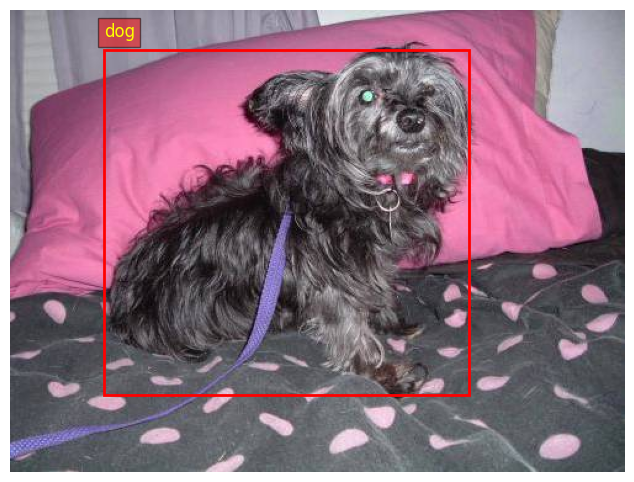

torch.Size([374, 500, 3])


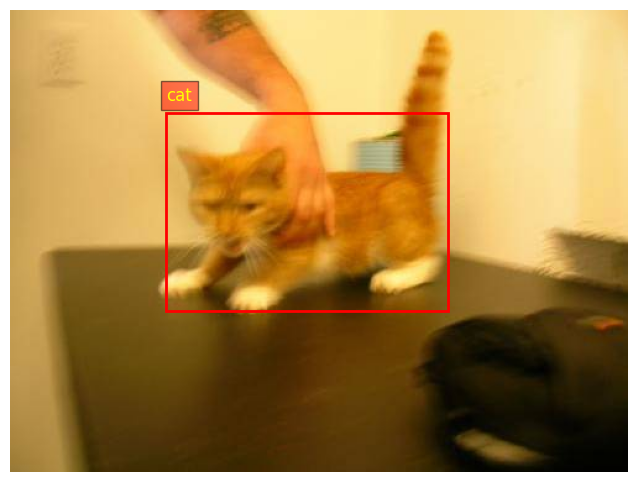

In [ ]:
data_dir = os.path.join("animals_extracted", "Asirra: cat vs dogs")
xml_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".xml")])
try:
    dog_index = xml_files.index("dog.0.xml")
    cat_index = xml_files.index("cat.0.xml")
    print(f"Индекс файла 'dog.0.xml': {dog_index}")
    print(f"Индекс файла 'cat.0.xml': {cat_index}")
except ValueError:
    print("Файл 'dog.0.xml' не найден.")

image_dog, target_dog = dataset[dog_index]
image_cat, target_cat = dataset[cat_index]

bbox_dog = target_dog["boxes"].data[0].tolist()
label_dog = target_dog["labels"]
bbox_cat = target_cat["boxes"].data[0].tolist()
label_cat = target_cat["labels"]


show_image_with_bounding_box(image_dog, bbox_dog, label_dog)
show_image_with_bounding_box(image_cat, bbox_cat, label_cat)

<p class="task" id="4"></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import torch
import torch.nn as nn

In [ ]:
class TwoHeadModel(nn.Module):
  def __init__(self, num_classes):
    super(TwoHeadModel, self).__init__()
    self.num_classes = num_classes
    self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    for param in self.backbone.parameters():
      param.requires_grad = False

    self.backbone.fc = nn.Identity()
    self.regressor = nn.Sequential(
        nn.Linear(2048, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 4),
        nn.Sigmoid()
    )
    self.classifier = nn.Sequential(
			nn.Linear(2048, 512),
			nn.ReLU(),
			nn.Dropout(),
			nn.Linear(512, 512),
			nn.ReLU(),
			nn.Dropout(),
			nn.Linear(512, self.num_classes)
    )

  def forward(self, x):
    features = self.backbone(x)
    bboxes = self.regressor(features)
    class_output = self.classifier(features)

    return (bboxes, class_output)


<p class="task" id="5"></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class AnimalDetectionDataset(Dataset):
    def __init__(self, root, transforms=None, target_transform = None, return_scaled=True):
        self.root = root
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled
        data_dir = os.path.join(root, "Asirra: cat vs dogs")
        self.imgs = sorted([f for f in os.listdir(data_dir) if f.endswith(".jpg")])
        self.xmls = sorted([f for f in os.listdir(data_dir) if f.endswith(".xml")])
        assert len(self.imgs) == len(self.xmls), "Number of images and masks dont match"

    def __getitem__(self, index):
        img_name = self.imgs[index]
        xml_name = self.xmls[index]
        img_path = os.path.join(self.root, "Asirra: cat vs dogs", img_name)
        xml_path = os.path.join(self.root, "Asirra: cat vs dogs", xml_name)
        image = Image.open(img_path).convert("RGB")
        parsed_data = parse_xml(xml_path)
        bbox_coords = parsed_data["scaled"] if self.return_scaled else parsed_data["raw"]
        obj_name = parsed_data["obj_name"]

        # print(f"Index {index}: Parsed object name: {obj_name}")
        # print(f"Image: {img_name}, Label from XML: {obj_name}")

        if self.target_transform:
          label = self.target_transform(obj_name)
        else:
          label = obj_name

        image = tv_tensors.Image(image)
        original_size = image.shape[-2:]
        original_w, original_h = original_size[::-1]
        if not self.return_scaled:
            scale_x = 224 / original_w
            scale_y = 224 / original_h
            bbox_coords = {
                "xmin": bbox_coords["xmin"] * scale_x,
                "ymin": bbox_coords["ymin"] * scale_y,
                "xmax": bbox_coords["xmax"] * scale_x,
                "ymax": bbox_coords["ymax"] * scale_y
            }

        target = {
            "boxes": tv_tensors.BoundingBoxes([list(bbox_coords.values())], format="XYXY", canvas_size=[224, 224]),
            "labels": label
        }

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target


    def __len__(self):
      return len(self.imgs)



In [ ]:
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, random_split

image_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def label_to_id(label):
  return 0 if label=="cat" else 1

dataset = AnimalDetectionDataset(
    root="animals_extracted",
    transforms=image_transform,
    target_transform=label_to_id,
    return_scaled=True
)

images = [0, 1, 10, 20, 550, 570, 600, 700]

for image in images:
  image, target = dataset[image]

print("Image shape:", image.shape)
print("Bounding Box Coordinates:", target["boxes"])
print("Label:", target["labels"])

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

def collate_fn(batch):
  images, targets = zip(*batch)
  return list(images), list(targets)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoHeadModel(num_classes=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
classification_loss = nn.CrossEntropyLoss()
regression_loss = nn.MSELoss()

Image shape: torch.Size([3, 224, 224])
Bounding Box Coordinates: BoundingBoxes([[0.1982, 0.2665, 0.9620, 0.9087]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224])
Label: 1


In [ ]:
best_val_loss = float("inf")

for epoch in range(30):
  model.train()
  train_total_loss = 0
  for image, target in train_loader:
      image = torch.stack(image).to(device)
      bbox_coords = torch.stack([t["boxes"].to(torch.float32).squeeze(0) for t in target]).to(device)
      # print(f"coords train: {bbox_coords[0]}")
      label = torch.tensor([t["labels"] for t in target]).to(device)

      bboxes_pred, class_output = model(image)
      # print(f"bbox_pred train: {bboxes_pred[0]}")

      cls_loss = classification_loss(class_output, label)
      reg_loss = regression_loss(bboxes_pred, bbox_coords)
      loss = cls_loss + reg_loss

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_total_loss += loss.item()

  model.eval()
  val_total_loss = 0
  with torch.no_grad():
    for image, target in val_loader:
      image = torch.stack(image).to(device)
      bbox_coords = torch.stack([t["boxes"].to(torch.float32).squeeze(0) for t in target]).to(device)
      # print(f"coords eval: {bbox_coords[0]}")
      label = torch.tensor([t["labels"] for t in target]).to(device).squeeze()
      # labels = torch.tensor([t["labels"] for t in target], dtype=torch.long, device=device)



      bboxes_pred, class_output = model(image)
      # print(f"bbox_pred eval: {bboxes_pred[0]}")
      cls_loss = classification_loss(class_output, label)
      reg_loss = regression_loss(bboxes_pred, bbox_coords)
      loss = cls_loss + reg_loss
      val_total_loss += loss.item()

  print(f"Epoch {epoch+1}: Train Loss = {train_total_loss:.4f}, Val Loss = {val_total_loss:.4f}")
  if val_total_loss < best_val_loss:
        best_val_loss = val_total_loss
        torch.save(model.state_dict(), "twohead_best.pth")



Epoch 1: Train Loss = 60.4876, Val Loss = 4.1906
Epoch 2: Train Loss = 20.5668, Val Loss = 2.3445
Epoch 3: Train Loss = 14.0942, Val Loss = 2.0698
Epoch 4: Train Loss = 10.4979, Val Loss = 1.8769
Epoch 5: Train Loss = 10.4095, Val Loss = 1.7560
Epoch 6: Train Loss = 8.8790, Val Loss = 2.8675
Epoch 7: Train Loss = 8.5922, Val Loss = 1.5959
Epoch 8: Train Loss = 8.1402, Val Loss = 1.5448
Epoch 9: Train Loss = 7.8412, Val Loss = 1.3007
Epoch 10: Train Loss = 6.1944, Val Loss = 1.1977
Epoch 11: Train Loss = 6.5872, Val Loss = 1.5090
Epoch 12: Train Loss = 6.1351, Val Loss = 1.7118
Epoch 13: Train Loss = 7.1577, Val Loss = 2.1377
Epoch 14: Train Loss = 5.4681, Val Loss = 1.7506
Epoch 15: Train Loss = 5.1917, Val Loss = 2.5759
Epoch 16: Train Loss = 5.5701, Val Loss = 2.1469
Epoch 17: Train Loss = 6.4791, Val Loss = 1.6373
Epoch 18: Train Loss = 4.3736, Val Loss = 1.4177
Epoch 19: Train Loss = 4.2365, Val Loss = 2.1642
Epoch 20: Train Loss = 4.2330, Val Loss = 2.0384
Epoch 21: Train Loss = 3

In [ ]:
from collections import Counter

counter = Counter()

for idx in range(len(dataset)):
    _, target = dataset[idx]
    label = target["labels"]
    counter[label] += 1

print(counter)


Counter({1: 552, 0: 548})


<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> BoundingBoxes([[0.2520, 0.2219, 0.7080, 0.6497]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]) [224, 224]
orig image shapetorch.Size([3, 224, 224])
orig bboxes: {'boxes': BoundingBoxes([[0.2520, 0.2219, 0.7080, 0.6497]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]), 'labels': 0}
image input shape: torch.Size([1, 3, 224, 224])
pred bbox: tensor([[0.2813, 0.2565, 0.8030, 0.6540]], device='cuda:0',
       grad_fn=<SigmoidBackward0>), class_pred: tensor([[ 5.5711, -6.5588]], device='cuda:0', grad_fn=<AddmmBackward0>), label: cat
denorm shape torch.Size([3, 224, 224])

▶️ Предсказанная рамка (норм): tensor([0.2813, 0.2565, 0.8030, 0.6540])
✅ Предсказанная рамка (пиксели): tensor([ 63,  57, 180, 146], dtype=torch.int32)
🟦 Истинная рамка (норм): tensor([0.2520, 0.2219, 0.7080, 0.6497])
🟩 Истинная рамка (пиксели): tensor([ 56,  50, 159, 146], dtype=torch.int32)


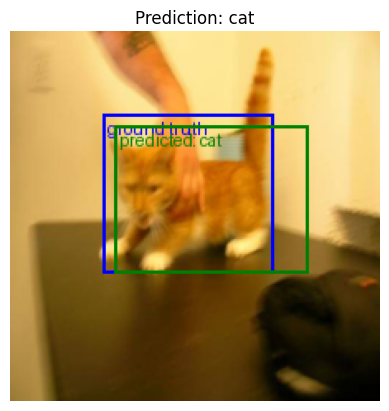

None
<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> BoundingBoxes([[0.1733, 0.1107, 0.9967, 0.9929]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]) [224, 224]
orig image shapetorch.Size([3, 224, 224])
orig bboxes: {'boxes': BoundingBoxes([[0.1733, 0.1107, 0.9967, 0.9929]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]), 'labels': 0}
image input shape: torch.Size([1, 3, 224, 224])
pred bbox: tensor([[0.0811, 0.0561, 0.9509, 0.9637]], device='cuda:0',
       grad_fn=<SigmoidBackward0>), class_pred: tensor([[ 3.6424, -4.2949]], device='cuda:0', grad_fn=<AddmmBackward0>), label: cat
denorm shape torch.Size([3, 224, 224])

▶️ Предсказанная рамка (норм): tensor([0.0811, 0.0561, 0.9509, 0.9637])
✅ Предсказанная рамка (пиксели): tensor([ 18,  13, 213, 216], dtype=torch.int32)
🟦 Истинная рамка (норм): tensor([0.1733, 0.1107, 0.9967, 0.9929])
🟩 Истинная рамка (пиксели): tensor([ 39,  25, 223, 222], dtype=torch.int32)


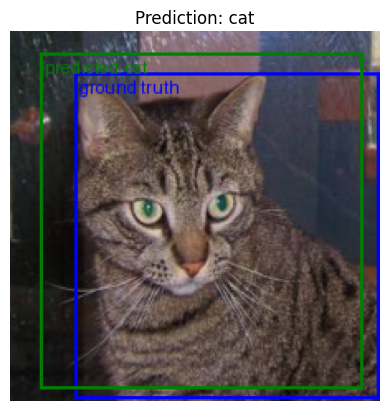

None
<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> BoundingBoxes([[0.1280, 0.0027, 0.8940, 0.8850]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]) [224, 224]
orig image shapetorch.Size([3, 224, 224])
orig bboxes: {'boxes': BoundingBoxes([[0.1280, 0.0027, 0.8940, 0.8850]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]), 'labels': 0}
image input shape: torch.Size([1, 3, 224, 224])
pred bbox: tensor([[0.0436, 0.0327, 0.9687, 0.9660]], device='cuda:0',
       grad_fn=<SigmoidBackward0>), class_pred: tensor([[ 3.2506, -3.8367]], device='cuda:0', grad_fn=<AddmmBackward0>), label: cat
denorm shape torch.Size([3, 224, 224])

▶️ Предсказанная рамка (норм): tensor([0.0436, 0.0327, 0.9687, 0.9660])
✅ Предсказанная рамка (пиксели): tensor([ 10,   7, 217, 216], dtype=torch.int32)
🟦 Истинная рамка (норм): tensor([0.1280, 0.0027, 0.8940, 0.8850])
🟩 Истинная рамка (пиксели): tensor([ 29,   1, 200, 198], dtype=torch.int32)


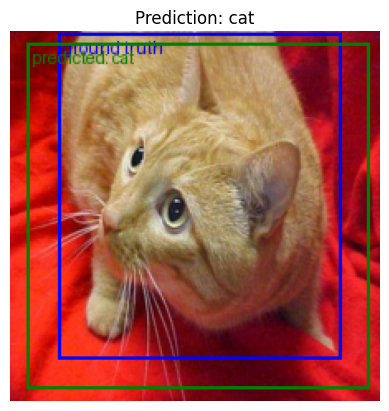

None
<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> BoundingBoxes([[0.3679, 0.0968, 0.8369, 0.6254]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]) [224, 224]
orig image shapetorch.Size([3, 224, 224])
orig bboxes: {'boxes': BoundingBoxes([[0.3679, 0.0968, 0.8369, 0.6254]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]), 'labels': 0}
image input shape: torch.Size([1, 3, 224, 224])
pred bbox: tensor([[0.3056, 0.1973, 0.7776, 0.8345]], device='cuda:0',
       grad_fn=<SigmoidBackward0>), class_pred: tensor([[ 5.9451, -7.0606]], device='cuda:0', grad_fn=<AddmmBackward0>), label: cat
denorm shape torch.Size([3, 224, 224])

▶️ Предсказанная рамка (норм): tensor([0.3056, 0.1973, 0.7776, 0.8345])
✅ Предсказанная рамка (пиксели): tensor([ 68,  44, 174, 187], dtype=torch.int32)
🟦 Истинная рамка (норм): tensor([0.3679, 0.0968, 0.8369, 0.6254])
🟩 Истинная рамка (пиксели): tensor([ 82,  22, 187, 140], dtype=torch.int32)


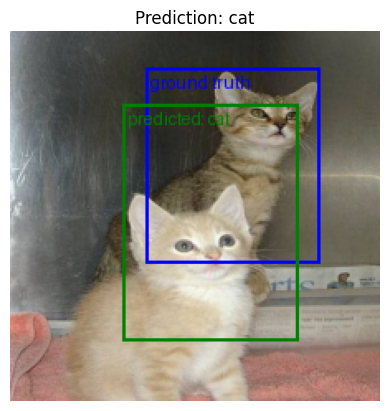

None
<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> BoundingBoxes([[0.1513, 0.0846, 0.7459, 0.8317]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]) [224, 224]
orig image shapetorch.Size([3, 224, 224])
orig bboxes: {'boxes': BoundingBoxes([[0.1513, 0.0846, 0.7459, 0.8317]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]), 'labels': 1}
image input shape: torch.Size([1, 3, 224, 224])
pred bbox: tensor([[0.1309, 0.1029, 0.8164, 0.9348]], device='cuda:0',
       grad_fn=<SigmoidBackward0>), class_pred: tensor([[-2.8138,  2.5361]], device='cuda:0', grad_fn=<AddmmBackward0>), label: dog
denorm shape torch.Size([3, 224, 224])

▶️ Предсказанная рамка (норм): tensor([0.1309, 0.1029, 0.8164, 0.9348])
✅ Предсказанная рамка (пиксели): tensor([ 29,  23, 183, 209], dtype=torch.int32)
🟦 Истинная рамка (норм): tensor([0.1513, 0.0846, 0.7459, 0.8317])
🟩 Истинная рамка (пиксели): tensor([ 34,  19, 167, 186], dtype=torch.int32)


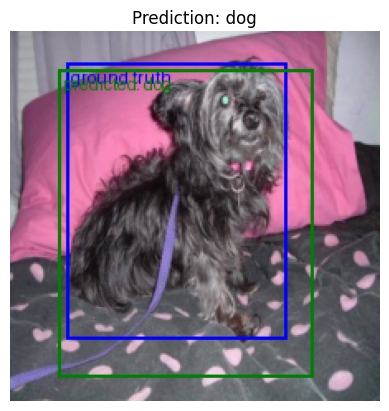

None
<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> BoundingBoxes([[0.0970, 0.0526, 0.8509, 0.9889]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]) [224, 224]
orig image shapetorch.Size([3, 224, 224])
orig bboxes: {'boxes': BoundingBoxes([[0.0970, 0.0526, 0.8509, 0.9889]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]), 'labels': 1}
image input shape: torch.Size([1, 3, 224, 224])
pred bbox: tensor([[0.0770, 0.0448, 0.9050, 0.9816]], device='cuda:0',
       grad_fn=<SigmoidBackward0>), class_pred: tensor([[-5.8008,  5.2382]], device='cuda:0', grad_fn=<AddmmBackward0>), label: dog
denorm shape torch.Size([3, 224, 224])

▶️ Предсказанная рамка (норм): tensor([0.0770, 0.0448, 0.9050, 0.9816])
✅ Предсказанная рамка (пиксели): tensor([ 17,  10, 203, 220], dtype=torch.int32)
🟦 Истинная рамка (норм): tensor([0.0970, 0.0526, 0.8509, 0.9889])
🟩 Истинная рамка (пиксели): tensor([ 22,  12, 191, 222], dtype=torch.int32)


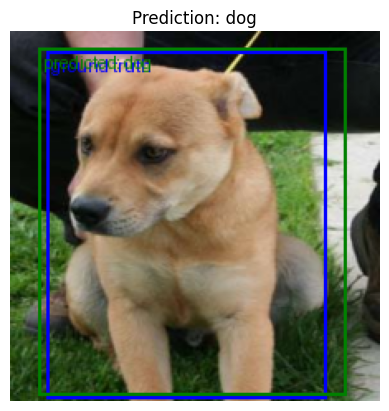

None
<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> BoundingBoxes([[0.1536, 0.1185, 1.0000, 1.0000]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]) [224, 224]
orig image shapetorch.Size([3, 224, 224])
orig bboxes: {'boxes': BoundingBoxes([[0.1536, 0.1185, 1.0000, 1.0000]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]), 'labels': 1}
image input shape: torch.Size([1, 3, 224, 224])
pred bbox: tensor([[0.1022, 0.0825, 0.8906, 0.9564]], device='cuda:0',
       grad_fn=<SigmoidBackward0>), class_pred: tensor([[-5.2788,  4.8915]], device='cuda:0', grad_fn=<AddmmBackward0>), label: dog
denorm shape torch.Size([3, 224, 224])

▶️ Предсказанная рамка (норм): tensor([0.1022, 0.0825, 0.8906, 0.9564])
✅ Предсказанная рамка (пиксели): tensor([ 23,  18, 200, 214], dtype=torch.int32)
🟦 Истинная рамка (норм): tensor([0.1536, 0.1185, 1.0000, 1.0000])
🟩 Истинная рамка (пиксели): tensor([ 34,  27, 224, 224], dtype=torch.int32)


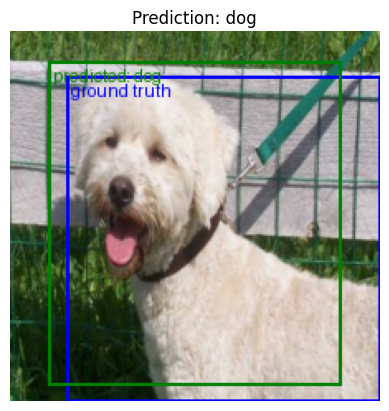

None
<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> BoundingBoxes([[0.1982, 0.2665, 0.9620, 0.9087]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]) [224, 224]
orig image shapetorch.Size([3, 224, 224])
orig bboxes: {'boxes': BoundingBoxes([[0.1982, 0.2665, 0.9620, 0.9087]], format=BoundingBoxFormat.XYXY, canvas_size=[224, 224]), 'labels': 1}
image input shape: torch.Size([1, 3, 224, 224])
pred bbox: tensor([[0.1922, 0.1423, 0.8400, 0.8865]], device='cuda:0',
       grad_fn=<SigmoidBackward0>), class_pred: tensor([[-3.5474,  3.2582]], device='cuda:0', grad_fn=<AddmmBackward0>), label: dog
denorm shape torch.Size([3, 224, 224])

▶️ Предсказанная рамка (норм): tensor([0.1922, 0.1423, 0.8400, 0.8865])
✅ Предсказанная рамка (пиксели): tensor([ 43,  32, 188, 199], dtype=torch.int32)
🟦 Истинная рамка (норм): tensor([0.1982, 0.2665, 0.9620, 0.9087])
🟩 Истинная рамка (пиксели): tensor([ 44,  60, 215, 204], dtype=torch.int32)


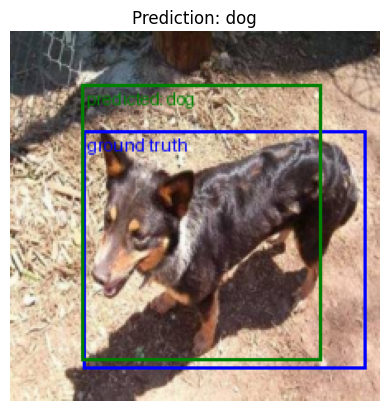

None


In [ ]:
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device)
    img_tensor = img_tensor * std[:, None, None] + mean[:, None, None]
    return (img_tensor * 255).clamp(0, 255).byte()

def show_prediction(index):
    model.eval()
    image, target = dataset[index]
    print(type(target['boxes']), target['boxes'], target['boxes'].canvas_size)

    print(f"orig image shape{image.shape}")
    print(f"orig bboxes: {target}")
    image_input = image.unsqueeze(0).to(device)
    print(f"image input shape: {image_input.shape}")

    bbox_pred, class_pred = model(image_input)
    label_id = class_pred.argmax(1).item()
    label_name = "cat" if label_id == 0 else "dog"
    print(f"pred bbox: {bbox_pred}, class_pred: {class_pred}, label: {label_name}")

    denorm_img = denormalize(image.cpu())
    print(f"denorm shape {denorm_img.shape}")
    _, H, W = denorm_img.shape
    bbox_norm_pred = bbox_pred[0].detach().cpu()

    bbox_pred_abs = (bbox_pred[0].detach().cpu() * torch.tensor([W, H, W, H])).round().int()

    bbox_norm_gt = target['boxes'][0]
    bbox_gt_abs = (target['boxes'][0] * torch.tensor([W, H, W, H])).round().int()

    print(f"\n▶️ Предсказанная рамка (норм): {bbox_norm_pred}")
    print(f"✅ Предсказанная рамка (пиксели): {bbox_pred_abs}")
    print(f"🟦 Истинная рамка (норм): {bbox_norm_gt}")
    print(f"🟩 Истинная рамка (пиксели): {bbox_gt_abs}")

    all_boxes = torch.stack([bbox_gt_abs, bbox_pred_abs])
    all_labels = ["ground truth", f"predicted: {label_name}"]
    all_colors = ["blue", "green"]

    drawn = draw_bounding_boxes(
        denorm_img,
        boxes=all_boxes,
        labels=all_labels,
        colors=all_colors,
        width=2,
        font_size=14
    )

    plt.imshow(F.to_pil_image(drawn))
    plt.title(f"Prediction: {label_name}")
    plt.axis("off")
    plt.show()


images = [0, 1, 10, 20, 550, 570, 600, 700]
for i in images:
  print(show_prediction(i))

<p class="task" id="6"></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

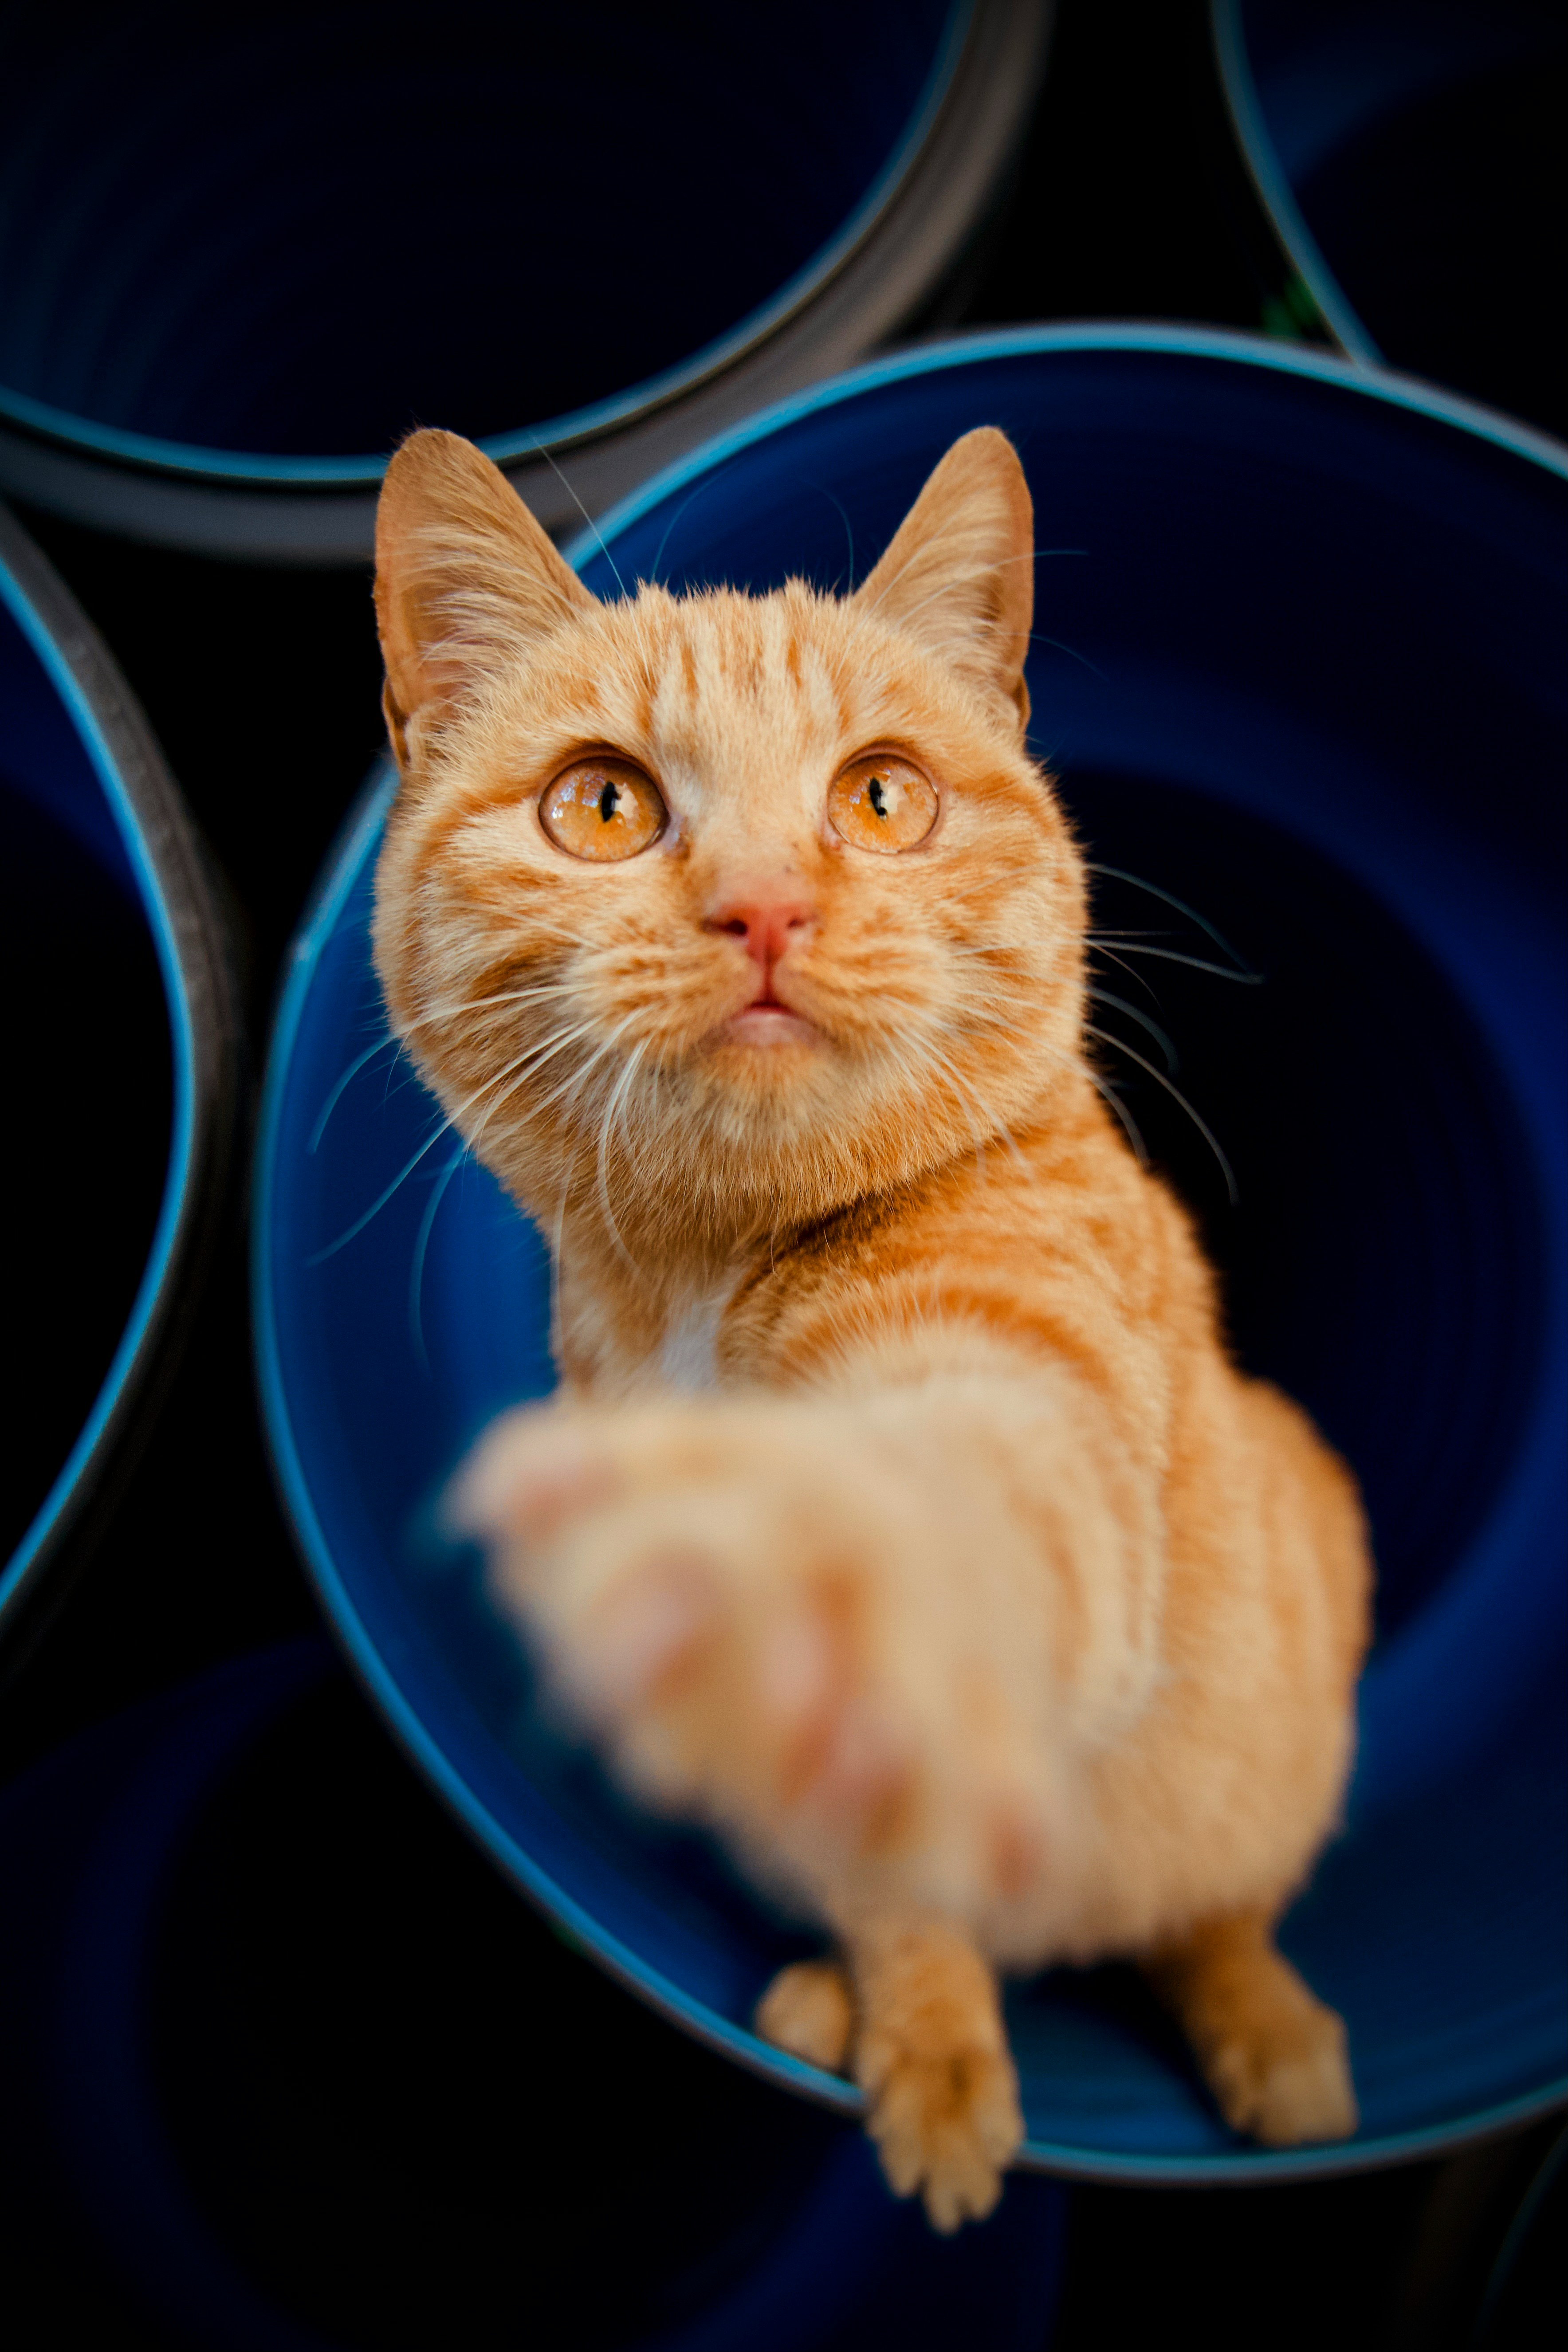

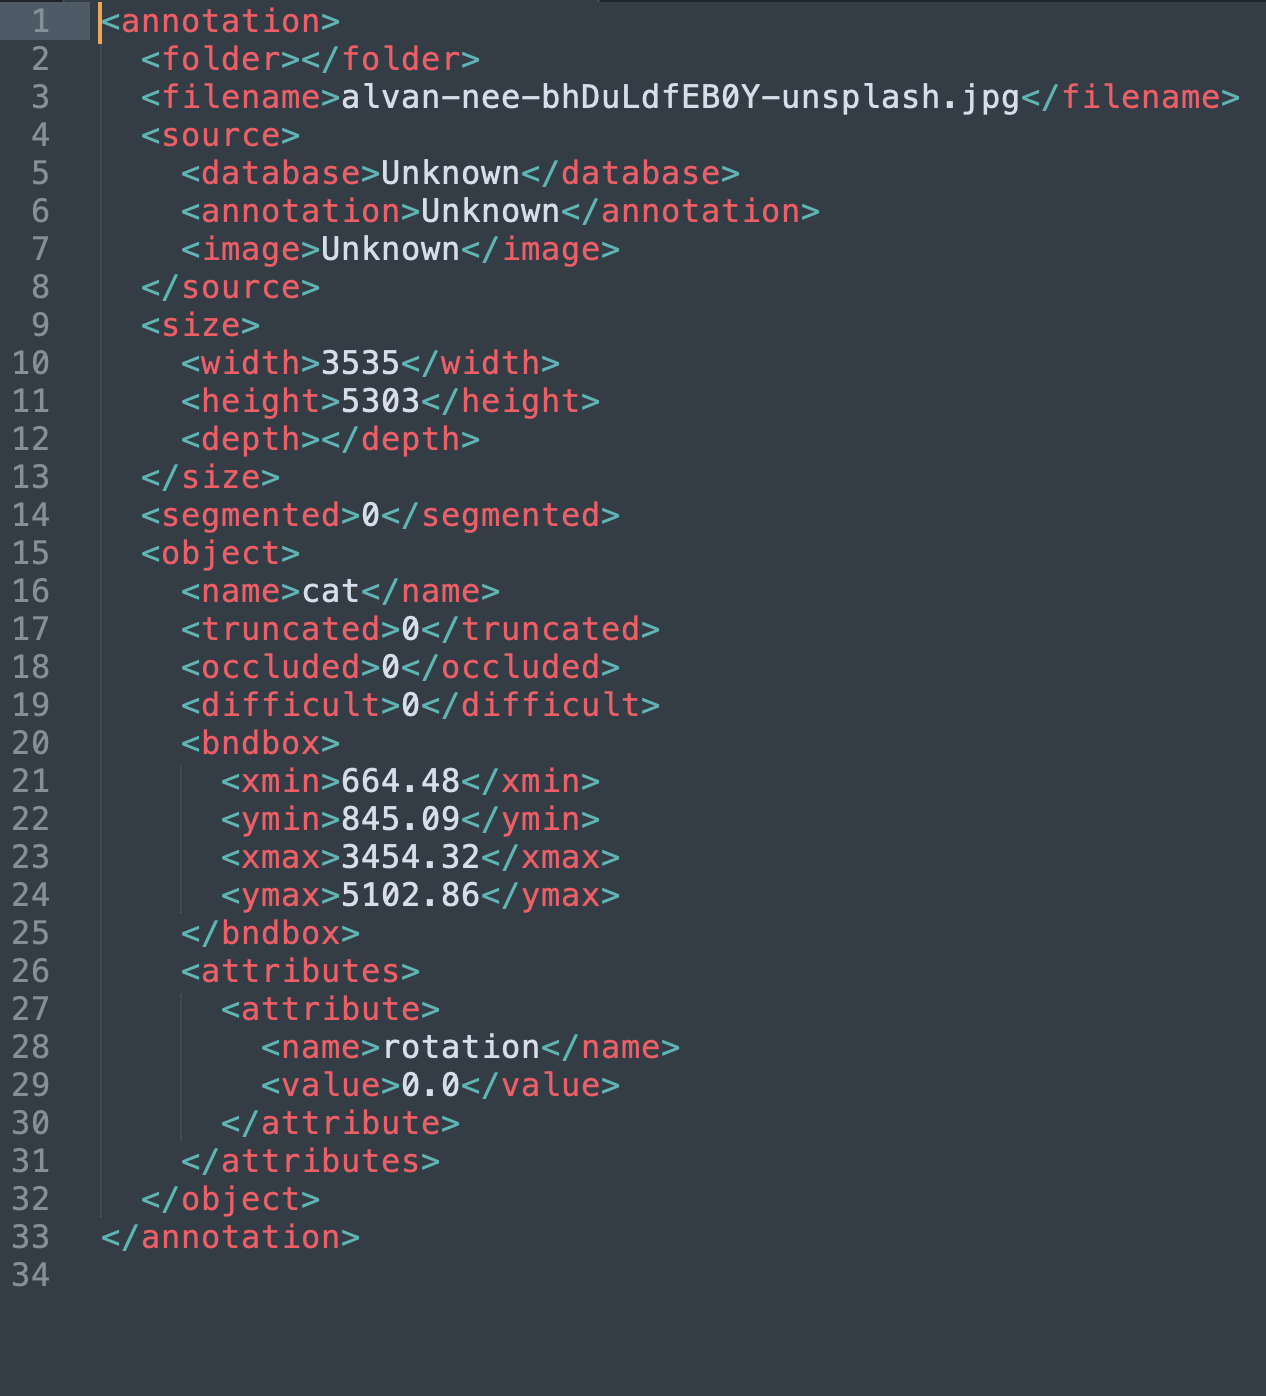

In [ ]:
import xml.etree.ElementTree as ET

def parse_voc(xml_file):

  tree = ET.parse(xml_file)
  root = tree.getroot()
  size = root.find("size")
  boxes, labels = [], []
  width = int(float(size.find("width").text))
  height = int(float(size.find("height").text))
  for obj in root.findall("object"):
    labels.append(obj.findtext("name"))
    bb = obj.find("bndbox")
    box = [float(bb.findtext(t)) for t in ("xmin","ymin","xmax","ymax")]
    boxes.append(box)
  return torch.tensor(boxes), labels, (width, height)




In [ ]:
from torchvision.ops import box_iou

def show_gt_and_pred(img_path, xml_path, model, device="cuda", save_dir="output"):

  os.makedirs(save_dir, exist_ok=True)
  pil = Image.open(img_path).convert("RGB")
  img_tf = F.resize(F.to_tensor(pil)*255, [224, 224])
  img_tf = F.normalize(img_tf/255.,
                       mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225]).unsqueeze(0).to(device)

  model.eval()
  with torch.no_grad():
    bb_pred, cls_pred = model(img_tf)
  label_id = cls_pred.argmax(1).item()
  pred_lbl = ["cat", "dog"][label_id]
  W, H = pil.size
  bb = bb_pred[0].cpu()
  bb = bb_pred[0].cpu()
  bb_xyxy = torch.tensor([
      bb[[0, 2]].min() * W,
      bb[[1, 3]].min() * H,
      bb[[0, 2]].max() * W,
      bb[[1, 3]].max() * H
  ]).unsqueeze(0).round().int()


  gt_boxes, gt_labels, _ = parse_voc(xml_path)
  gt_boxes = gt_boxes.round().int()

  iou = box_iou(gt_boxes.float(), bb_xyxy.float())[0][0].item()

  print("bbox_pred tensor:", bb_xyxy)



  img_draw = draw_bounding_boxes(
        F.to_tensor(pil),
        boxes=torch.cat([gt_boxes, bb_xyxy]),
        labels=gt_labels + [f"pred:{pred_lbl}, IoU={iou:.2f}"],
        colors=["red"] * len(gt_boxes) + ["green"],
        width=15
    )

  result_img = F.to_pil_image(img_draw)
  fname = os.path.basename(img_path)
  result_img.save(os.path.join(save_dir, f"vis_{fname}"))

  plt.figure(figsize=(8, 8))
  plt.imshow(result_img)
  plt.axis("off")
  plt.title(f"Prediction: {pred_lbl}, IoU: {iou:.2f}")
  plt.show()

bbox_pred tensor: tensor([[ 192,  181, 3357, 5227]], dtype=torch.int32)


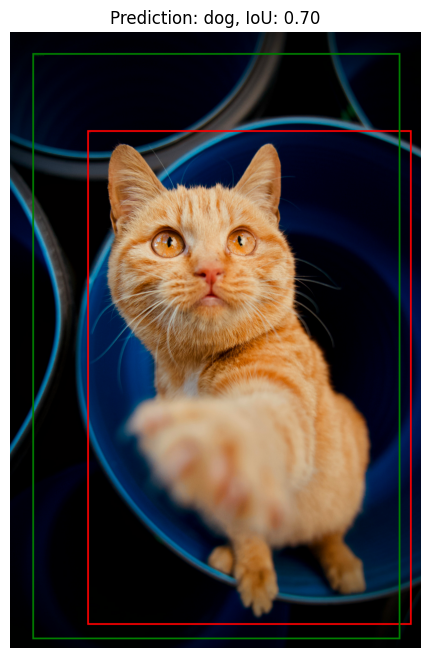

bbox_pred tensor: tensor([[ 171,  135, 2712, 3718]], dtype=torch.int32)


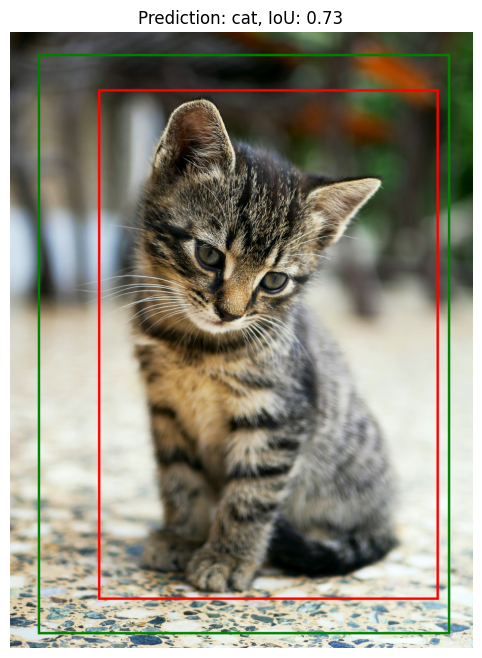

bbox_pred tensor: tensor([[ 548,  637, 3439, 5629]], dtype=torch.int32)


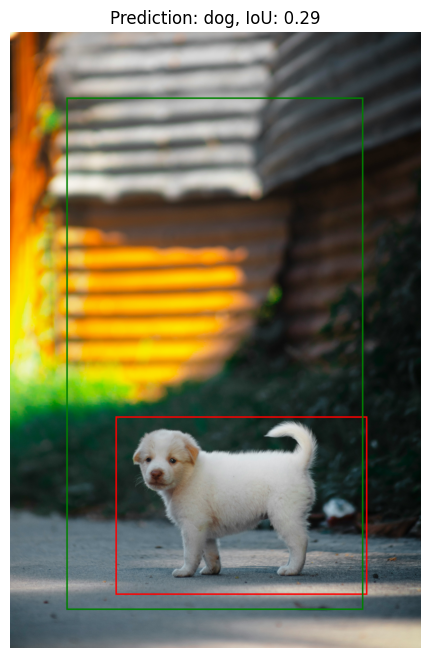

bbox_pred tensor: tensor([[ 782,  404, 3748, 2677]], dtype=torch.int32)


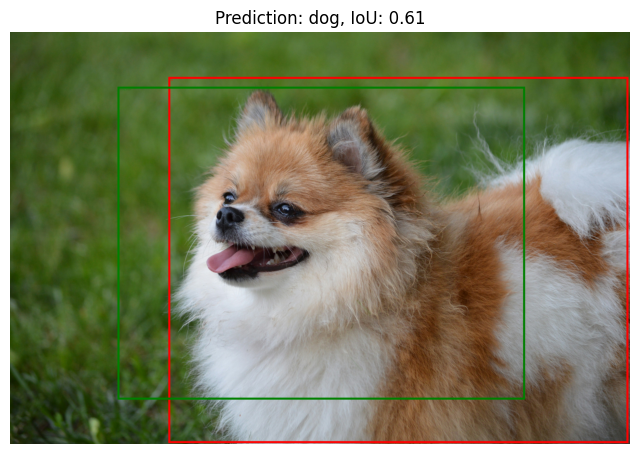

In [ ]:
import zipfile
import os
from pathlib import Path
import xml.etree.ElementTree as ET
import torch

zip_file_path = "cat_dog 2.zip"
extract_dir = "cat_dog_extracted"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

root_dir = Path(extract_dir) / "cat_dog"
ann_dir = root_dir / "Annotations"
img_dir = root_dir / "JPEGImages"

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TwoHeadModel(num_classes=2)
model.load_state_dict(torch.load("twohead_best.pth", map_location=device))
model.to(device).eval()

for xml_path in sorted(ann_dir.glob("*.xml")):
    try:
        tree = ET.parse(xml_path)
        root_xml = tree.getroot()
        filename = root_xml.findtext("filename") or (xml_path.stem + ".jpg")

        img_path = img_dir / filename

        if img_path.exists():
            show_gt_and_pred(str(img_path), str(xml_path), model, device=device)
        else:
            print(f"[WARN] Изображение не найдено: {img_path.name}")

    except Exception as e:
        print(f"[ERROR] Ошибка при обработке {xml_path.name}: {e}")




<p class="task" id="7"></p>

7*\. Повторите решение предыдущей задачи, используя модель `fasterrcnn_resnet50_fpn`. Замените слой для предсказания bounding box на `FastRCNNPredictor` с нужным количеством классов.

- [ ] Проверено на семинаре

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [57]:
zip_file_path = "pascal.zip"
extract_dir = "pascal_extracted"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

In [58]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
class AnimalDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None, target_transform=None, return_scaled=True):
    self.root = root
    self.transforms = transforms
    self.target_transform = target_transform
    self.return_scaled = return_scaled
    data_dir = os.path.join(root, "pascal/Annotations")
    self.imgs = sorted([f for f in os.listdir(data_dir) if f.endswith(".jpg")])
    self.xmls = sorted([f for f in os.listdir(data_dir) if f.endswith(".xml")])
    assert len(self.imgs) == len(self.xmls), "Number of images and masks dont match"

  def __getitem__(self, index):
    img_name = self.imgs[index]
    xml_name = self.xmls[index]
    img_path = os.path.join(self.root, "pascal/Annotations", img_name)
    xml_path = os.path.join(self.root, "pascal/Annotations", xml_name)
    img = Image.open(img_path).convert("RGB")
    parsed_data = parse_xml(xml_path)
    bbox_coords = parsed_data["scaled"] if self.return_scaled else parsed_data["raw"]
    label = parsed_data["obj_name"]
    if self.target_transform:
      label = self.target_transform(label)
    else:
      label = label

    image = tv_tensors.Image(image)
    orig_size = image.shape[-2:]
    orig_w, orig_h = orig_size[::-1]
    if not self.return_scaled:
      scale_x = 224 / orig_w
      scale_y = 224 / orig_h
      bbox_coords = {
          "xmin": bbox_coords["xmin"] * scale_x,
          "ymin": bbox_coords["ymin"] * scale_y,
          "xmax": bbox_coords["xmax"] * scale_x,
          "ymax": bbox_coords["ymax"] * scale_y
      }
    target = {
        "boxes": tv_tensors.BoundingBoxes([list(bbox_coords.values())], format="XYXY", canvas_size=[224, 224]),
        "labels": label
    }

    if self.transforms:
      image, target = self.transforms(image, target)

    return image, target

  def __len__(self):

    return len(self.imgs)



In [ ]:
from torchvision.transforms import v2 as T

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def label_to_id(label):
  return 0 if label=="cat" else 1

dataset = AnimalDataset(
    root="pascal_extracted",
    transforms=transform,
    target_transform=label_to_id,
    return_scaled=True
)

if len(dataset) == 0:
    raise ValueError("Dataset is empty!")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Обеспечить, чтобы train_size и val_size были хотя бы по 1, если dataset маленький
if train_size == 0:
    train_size = 1
    val_size = len(dataset) - 1
if val_size == 0 and train_size > 1:
    train_size -= 1
    val_size = 1

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_ds, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)
valid_loader = DataLoader(
    val_ds, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

classification_loss = nn.CrossEntropyLoss()
regression_loss = nn.MSELoss()

In [56]:
num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  for images, targets in train_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    losses.backward()
    optimizer.step()
    train_loss += losses.item()

  lr_scheduler.step()
  print(f'Epoch: {epoch + 1}, Loss: {train_loss / len(train_loader)}')


AttributeError: 'NoneType' object has no attribute 'find'

In [ ]:
best_val_loss = float("inf")

for epoch in range(30):
  model.train()
  train_total_loss = 0
  for image, target in train_loader:
      image = torch.stack(image).to(device)
      bbox_coords = torch.stack([t["boxes"].to(torch.float32).squeeze(0) for t in target]).to(device)
      # print(f"coords train: {bbox_coords[0]}")
      label = torch.tensor([t["labels"] for t in target]).to(device)

      bboxes_pred, class_output = model(image)
      # print(f"bbox_pred train: {bboxes_pred[0]}")

      cls_loss = classification_loss(class_output, label)
      reg_loss = regression_loss(bboxes_pred, bbox_coords)
      loss = cls_loss + reg_loss

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_total_loss += loss.item()

  model.eval()
  val_total_loss = 0
  with torch.no_grad():
    for image, target in val_loader:
      image = torch.stack(image).to(device)
      bbox_coords = torch.stack([t["boxes"].to(torch.float32).squeeze(0) for t in target]).to(device)
      # print(f"coords eval: {bbox_coords[0]}")
      label = torch.tensor([t["labels"] for t in target]).to(device).squeeze()
      # labels = torch.tensor([t["labels"] for t in target], dtype=torch.long, device=device)



      bboxes_pred, class_output = model(image)
      # print(f"bbox_pred eval: {bboxes_pred[0]}")
      cls_loss = classification_loss(class_output, label)
      reg_loss = regression_loss(bboxes_pred, bbox_coords)
      loss = cls_loss + reg_loss
      val_total_loss += loss.item()

  print(f"Epoch {epoch+1}: Train Loss = {train_total_loss:.4f}, Val Loss = {val_total_loss:.4f}")
  if val_total_loss < best_val_loss:
        best_val_loss = val_total_loss
        torch.save(model.state_dict(), "twohead_best.pth")



In [ ]:
zip_file_path = "task7.zip"
extract_dir = "task7_extracted"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
zip_file_path = "task7.zip"
extract_dir = "task7_extracted"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

root_dir = Path(extract_dir)
ann_dir = root_dir / "Annotations"
img_dir = root_dir / "iamges"

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoHeadModel(num_classes=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
classification_loss = nn.CrossEntropyLoss()
regression_loss = nn.MSELoss()

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)


model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [ ]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [ ]:
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = CatDog('cat_dog_extracted/cat_dog', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

In [ ]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

In [ ]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

## Обратная связь
- [ ] Хочу получить обратную связь по решению